In [1]:
%url='http://opendap.renci.org:1935/thredds/dodsC/Experiments/Isabel_ex1/ADCIRC/12km/n01/maxele.63.nc';
url='http://opendap.renci.org:1935/thredds/dodsC/daily/nam/2016030800/nc6b/hatteras.renci.org/dailyv51/namforecast/fort.63.nc';

In [2]:
which ncgeodataset

/Users/bblanton/matlab/nctoolbox/cdm/ncgeodataset.m  % ncgeodataset constructor


In [3]:
nc=ncgeodataset(url)

nc = 
  ncgeodataset with properties:

     location: 'http://opendap.renci.org:1935/thredds/dodsC/daily/nam/2016...'
       netcdf: [1x1 ucar.nc2.dataset.NetcdfDataset]
    variables: {17x1 cell}


In [4]:
% get an ncgeovariable from the ncgeodataset nc
zeta=nc{'zeta'}                    % this does NOT extract the data from the nc file.
time=nc.time('time');              % get time variable in datenum format
%dtime=datetime(datevec(time));     % create a datetime object

zeta = 
  84x295328 ncgeovariable array with properties:

       dataset: [1x1 ncgeodataset]
          name: 'zeta'
          axes: {3x1 cell}
    attributes: {7x2 cell}


In [5]:
% size of underlying data
temp=zeta.size;        % could have done size(zeta)
nt=temp(1);

In [6]:
% get the grid from the ncgeodataset object
fgs=ExtractGrid(nc);

In [7]:
% Compute strtree for grid
fgs.strtree=ComputeStrTree(fgs);

Computing STRtree for 575512 elements ... 
STRtree for 575512 elements computed in 27.2 secs


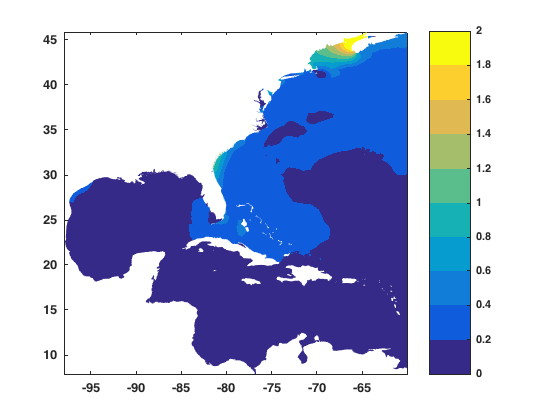

In [8]:
% make a color surface plot fo the first time level
zeta1=zeta.data(1,:)';  % this DOES extract data, getting the first time level from the ncgeovariable
colormesh2d(fgs,zeta1)
axis('equal')
axis('tight')
colorbar
set(gca,'FontSize',6)
caxis([0 2])
colormap(parula(10))

In [9]:
% point to locate in grid
lon1=[-80 -75];
lat1=[ 30  30];
nsta=length(lon1);

In [10]:
j=FindElementsInStrTree(fgs,lon1,lat1)

j =
       21327        8088


In [14]:
% Compute basis functions for lon1,lat1,j
%
n=fgs.e(j,:);  
xl=fgs.x(n);
yl=fgs.y(n);

% Form triangles for the element and 3 sub triangles
x=[ xl;  lon1' xl(:,2:3); xl(:,1) lon1' xl(:,3);  xl(:,1:2) lon1' ];
y=[ yl;  lat1' yl(:,2:3); yl(:,1) lat1' yl(:,3);  yl(:,1:2) lat1' ];

a=Area3(x,y);
a=reshape(a,length(lon1),4);
% divide the subareas by the element area in column 1
phi=bsxfun(@rdivide, a(:,2:4), a(:,1));

In [15]:
% Loop over stations and time to interpolate
% Because we are striding through the time dimension (index k below), 
% access is not as fast as getting node values out along a spatial dimension.
% Still,  it's faster than downloading the large ADCIRC file.
sta_z=nan(nt,nsta);
for k=1:nsta
    zlocal=nan(nt,3);
    for i=1:nt
        zlocal(i,1)=zeta.data(i,n(k,1));
        zlocal(i,2)=zeta.data(i,n(k,2));
        zlocal(i,3)=zeta.data(i,n(k,3));
        sta_z(i,k)=sum(zlocal(i,:).*phi(k,:));
    end
end

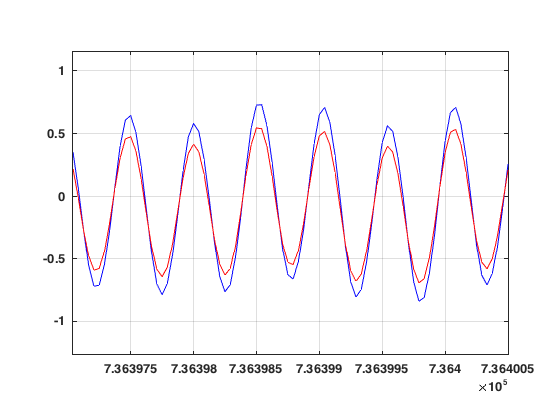

In [16]:
plot(time,sta_z);set(gca,'FontSize',6);axis('equal');grid